<a href="https://colab.research.google.com/github/Simon-creator-jara/Inteligencia_artificial/blob/main/Copia_de_GAN_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

Las redes generativas antagónicas (GAN, Generative Adversarial Networks) son un modelo de red neuronal que está compuesto por dos modelos. Estos modelos son entrenados simultáneamente por un proceso contradictorio. Un generador ("el artista") aprende a crear imágenes que parecen reales, mientras que un discriminador ("el crítico de arte") aprende a diferenciar las imágenes reales de las falsificaciones.
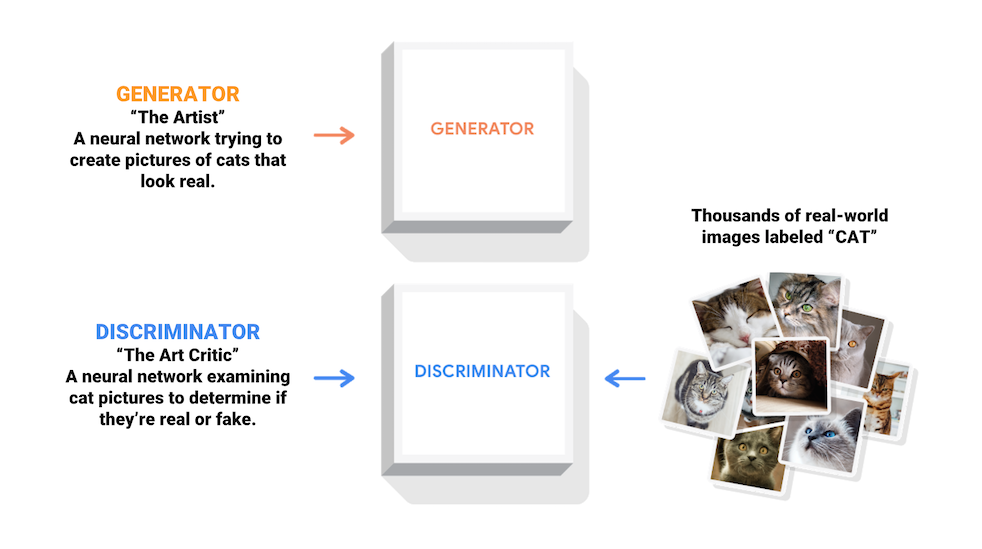





Tomado de: https://www.tensorflow.org/tutorials/generative/dcgan

En el entrenamiento el generador va mejorando en cada iteración para crear imágenes que parezcan reales, mientras que el discriminador mejora en diferenciarlas. El proceso alcanza el equilibrio cuando el discriminador ya no puede distinguir las imágenes reales de las falsificaciones.

In [ ]:
import tensorflow as tf

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Ejemplo con base de datos MNIST

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Creación de una tología de red GAN

Vamos a presentar acá una topología ed antagónica generativa convolucional profunda (DCGAN, Deep Convolutional Generative Adversarial Network).

### El generador

El generador usa capas Conv2DTranspose para producir una imagen desde una raíz, como un autoencoder. Comienza con una capa Dense que toma esta semilla de entrada, transforma la muestra varias veces hasta alcanzar el tamaño 28x28x1.

Utiliza una capa de activación LeakyRelu, execipto en la capa de salida que utiliza tanh.

LeakyRelu es una función de activación,donde la pendiente se cambia a la izquierda de x = 0, por lo tanto, provoca una fuga y amplía el rango de ReLU.Corrige el problema de activación RELU, donde algunas neuronas mueren para las entradas permaneciendo inactivas, lo cual puede afectar el rendimiento de la red si terminan muchas neuronas inactiva.

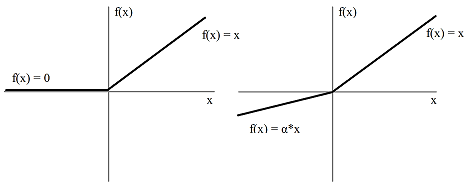

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model


Si usamos el generador sin entrenar la imagen

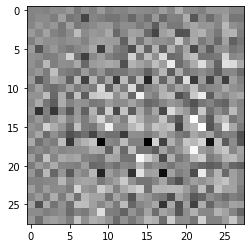

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### El discriminador
Este es un clasificador de imágenes basado en redes convolucionales

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

Si utilizamos el discriminador (todavía no entrenado) para clasificar las imágenes generadas como reales o falsas. El modelo se entrenará para generar valores positivos para imágenes reales y valores negativos para imágenes falsas.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00245715]], shape=(1, 1), dtype=float32)


### Definir la pérdida y los optimizadores

El método BinaryCrossentropy devuelve una función auxiliar para calcular la pérdida de entropía cruzada

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**Pérdida del discriminador** 

Este método cuantifica qué tan bien el discriminador es capaz de distinguir las imágenes reales de las falsificaciones. Compara las predicciones del discriminador sobre imágenes reales con una matriz de 1 y las predicciones del discriminador sobre imágenes falsas (generadas) con una matriz de 0.

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

**Pérdida del generador**

La pérdida del generador cuantifica qué tan bien pudo engañar al discriminador. Intuitivamente, si el generador funciona bien, el discriminador clasificará las imágenes falsas como reales (o 1). Aquí, compare las decisiones de los discriminadores en las imágenes generadas con una matriz de 1.

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

Los optimizadores del discriminador y el generador son diferentes pues son dos tipos de redes diferentes y separadas.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Guardar puntos de control
Vamos a guardar y restaurar los modelos, lo que puede ser útil en caso de que se interrumpa una tarea de entrenamiento de larga duración.

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Entrenamiento

El ciclo de entrenamiento comienza cuando el generador recibe una semilla aleatoria como entrada. Esa semilla se usa para producir una imagen. Luego, el discriminador se usa para clasificar imágenes reales (extraídas del conjunto de entrenamiento) e imágenes falsas (producidas por el generador). La pérdida se calcula para cada uno de estos modelos y los gradientes se utilizan para actualizar el generador y el discriminador.

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Para genera un GIF con diferentes salidad en varias iteraciones y ver el progreso se van a utilizar las siguientes bibliotecas

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-1f5atqna
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-1f5atqna


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images para hacer un GIF de salida
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Guardando el modelo cada 15 épocas
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Tiempo de la época {} : {} segundos'.format(epoch + 1, time.time()-start))

  # Generar después de la última época
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

### Entrenar el modelo

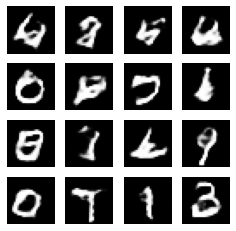

In [ ]:
train(train_dataset, EPOCHS)

Restaurar el último punto de control.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Crear un GIF

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

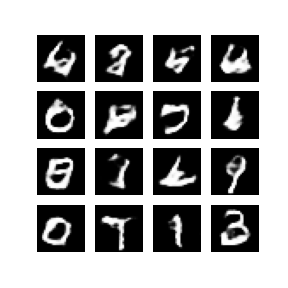

In [ ]:
display_image(EPOCHS)